In [1]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
from tensorflow.keras.datasets import mnist
(X_tn0, y_tn0), (X_te0, y_te0) = mnist.load_data()

In [4]:
print(X_tn0.shape)
print(y_tn0.shape)
print(X_te0.shape)
print(y_te0.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


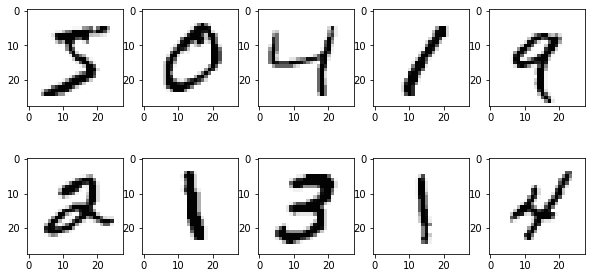

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn0[i].reshape((28, 28)), 
                cmap='Greys')
plt.show()

In [6]:
X_tn_re = X_tn0.reshape(60000, 28, 28, 1)
X_tn = X_tn_re/255
print(X_tn.shape)

(60000, 28, 28, 1)


In [8]:
X_te_re = X_te0.reshape(10000, 28, 28, 1)
X_te = X_te_re/255
print(X_te.shape)

(10000, 28, 28, 1)


In [9]:
# 노이즈 데이터
import numpy as np 
X_tn_noise = X_tn + np.random.uniform(-1, 1, size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1, 1, size=X_te.shape)

In [11]:
# 노이즈 데이터 스케일링
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

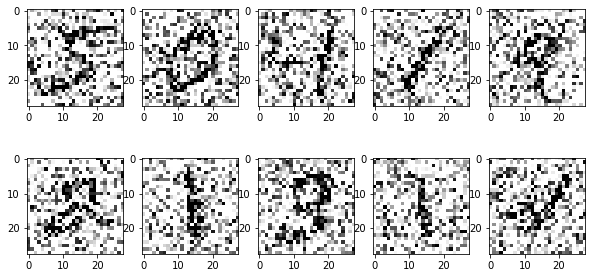

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn_ns[i].reshape((28, 28)), cmap='Greys')
plt.show()

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, Activation

# 인코더
input_layer1 = Input(shape=(28, 28, 1))
x1 = Conv2D(20, kernel_size=(5, 5), 
            padding='same')(input_layer1)
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPool2D(pool_size=2, padding='same')(x1)
encoder = Model(input_layer1, output_layer1)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


In [15]:
print(output_layer1.shape)

(None, 14, 14, 20)


In [17]:
print(output_layer1.shape[0])
print(output_layer1.shape[1])
print(output_layer1.shape[2])
print(output_layer1.shape[3])

None
14
14
20


In [18]:
# 디코더
input_layer2 = Input(shape=output_layer1.shape[1:4])
x2 = Conv2D(10, kernel_size=(5, 5), 
            padding='same')(input_layer2)
x2 = Activation(activation='relu')(x2)
x2 = UpSampling2D()(x2)
x2 = Conv2D(1, kernel_size=(5, 5), padding='same')(x2)
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14, 14, 20)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        5010      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 10)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         251       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 1)         0         
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________

In [19]:
# 오토 인코더 모형 생성
input_auto = Input(shape=(28, 28, 1))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto)
auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Model)                (None, 14, 14, 20)        520       
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         5261      
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


In [21]:
auto_encoder.compile(loss='mean_squared_error', 
                     optimizer='adam',
                     metrics=['mean_squared_error'])

In [23]:
hist = auto_encoder.fit(X_tn_ns, X_tn, 
                        epochs=1, 
                        batch_size=100)

Train on 60000 samples
60000/60000 [==============================] - 56s 942us/sample - loss: 0.0275 - mean_squared_error: 0.0275


In [24]:
X_pred = auto_encoder.predict(X_tn_ns)

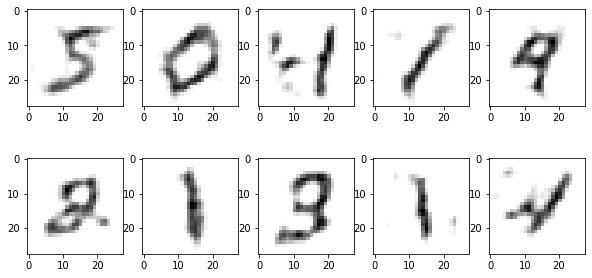

In [25]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_pred[i].reshape((28, 28)), cmap='Greys')
plt.show()